# Exploring Lung-PET-CT-Dx

In [2]:
# Import necessary libraries
import os
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:

# Load metadata to get the file path
metadata_path = Path('dataset') / 'metadata.csv'
metadata = pd.read_csv(metadata_path)

# Filter for CT modality
ct_metadata = metadata[metadata['Modality'] == 'CT'].copy()
# Convert backslashes to forward slashes
ct_metadata['File Location'] = ct_metadata['File Location'].str.replace('\\', '/')

In [ ]:
# Select the first CT file path from metadata
relative_path = ct_metadata.iloc[0]['File Location']

# Handle the possible nested directory structure
dataset_root = Path('dataset')

# boolean to check if the path is nested (check if scan_root has another child named Lung-PET-CT-Dx), evaluate a boolean expression
scan_root_is_nested = (dataset_root / 'Lung-PET-CT-Dx' / 'Lung-PET-CT-Dx' ).exists()

# Display the path
dicom_path = dataset_root / ( 'Lung-PET-CT-Dx' if scan_root_is_nested else '' ) / relative_path
dicom_path

PosixPath('dataset/Lung-PET-CT-Dx/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983')

In [4]:
# Read the DICOM series from directory
reader = sitk.ImageSeriesReader()
series_IDs = reader.GetGDCMSeriesIDs(dicom_path)
if not series_IDs:
    raise ValueError(f"No DICOM series found in {dicom_path}")

In [5]:
# Show the number of series found
print(f"Number of series found: {len(series_IDs)}")

Number of series found: 1


In [6]:

series_file_names = reader.GetGDCMSeriesFileNames(dicom_path, series_IDs[0])
reader.SetFileNames(series_file_names)
image = reader.Execute()

In [7]:
# Count the number of slices
num_slices = image.GetDepth()
print(f"Number of slices in the DICOM series: {num_slices}")

Number of slices in the DICOM series: 30


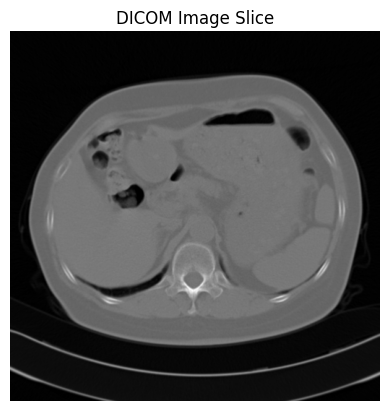

In [8]:
# Visualize the DICOM image
plt.imshow(sitk.GetArrayFromImage(image)[0], cmap='gray')
plt.title('DICOM Image Slice')
plt.axis('off')
plt.show()

In [21]:
from IPython.display import HTML
import matplotlib.animation as animation

def show_gif(image, num_slices):
    fig, ax = plt.subplots()
    ax.axis('off')
    
    img_array = sitk.GetArrayFromImage(image)
    frames = []
    for i in range(num_slices):
        im = ax.imshow(img_array[i], cmap='gray', animated=True)
        txt = ax.text(0.05, 0.95, f"Slice {i+1}/{num_slices}", transform=ax.transAxes,
                      color="red", fontsize=12, verticalalignment="top", animated=True)
        frames.append([im, txt])
    
    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# Display the animation inline
show_gif(image, num_slices)


Selected patient directory: dataset/Annotation/Annotation/A0001
Selected XML file: dataset/Annotation/Annotation/A0001/1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214.xml
Extracted UID: 1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214
Patient name (from XML folder): A0001
Searching DICOM files in: dataset/Lung-PET-CT-Dx/Lung-PET-CT-Dx/Lung_Dx-A0001
Found matching DICOM file: dataset/Lung-PET-CT-Dx/Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-Chest-07990/3.000000-5mm-41315/1-18.dcm
Displaying slice 46


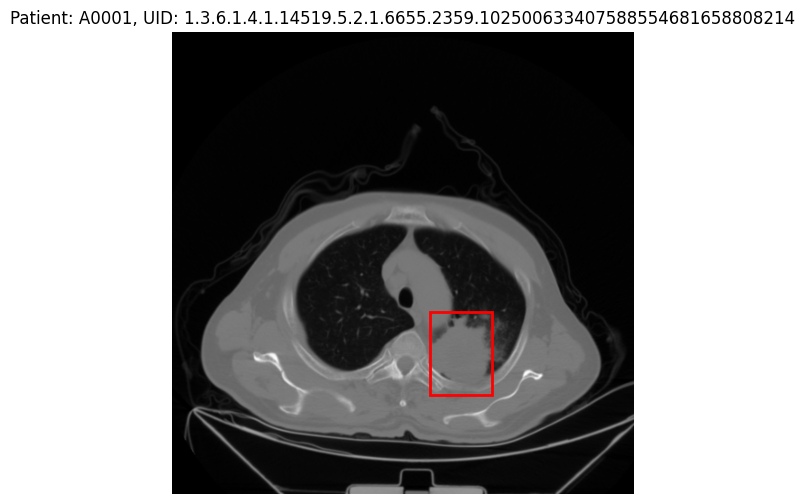

In [12]:
import pydicom
from pathlib import Path
import xml.etree.ElementTree as ET
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ----- Define directories -----
anno_root = Path('dataset') / 'Annotation' / 'Annotation'
dicom_root = Path('dataset') / 'Lung-PET-CT-Dx' / 'Lung-PET-CT-Dx'

# ----- 1. Locate the first patient directory in the annotations folder -----
patient_dirs = sorted([d for d in anno_root.iterdir() if d.is_dir()])
if not patient_dirs:
    raise RuntimeError("No patient directories found in the annotation folder.")
first_patient_dir = patient_dirs[0]
print("Selected patient directory:", first_patient_dir)

# ----- 2. Find the first XML file in that patient directory -----
xml_files = sorted(list(first_patient_dir.rglob("*.xml")))
if not xml_files:
    raise RuntimeError(f"No XML files found in patient directory {first_patient_dir}")
xml_file = xml_files[0]
print("Selected XML file:", xml_file)

# ----- 3. Parse the XML for bounding boxes and extract the UID -----
bbox_list = []
tree = ET.parse(xml_file)
for obj in tree.findall('.//object'):
    bb = obj.find('bndbox')
    coords = [int(float(bb.find(tag).text)) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
    bbox_list.append(coords)
uid = xml_file.stem
print("Extracted UID:", uid)

# ----- 4. Derive the patient name from the XML file's path -----
# Assume the patient directory name is the patient ID.
patient_name = xml_file.parent.name
print("Patient name (from XML folder):", patient_name)

# ----- 5. Restrict the DICOM search to the patient's directory -----
# Look for a folder in dicom_root whose name contains the patient name.
patient_dicom_dir = None
for folder in dicom_root.iterdir():
    if folder.is_dir() and patient_name in folder.name:
        patient_dicom_dir = folder
        break
if patient_dicom_dir is None:
    raise RuntimeError(f"No DICOM folder found for patient {patient_name} in {dicom_root}")
print("Searching DICOM files in:", patient_dicom_dir)

# ----- 6. Brute force search for a DICOM file with a matching SOPInstanceUID -----
found_dcm = None
for dcm_file in patient_dicom_dir.rglob("*.dcm"):
    try:
        ds = pydicom.dcmread(dcm_file, stop_before_pixels=True, force=True)
    except Exception:
        continue
    if getattr(ds, 'SOPInstanceUID', None) == uid:
        found_dcm = dcm_file
        break
if found_dcm is None:
    raise RuntimeError(f"No DICOM file found with UID {uid} in {patient_dicom_dir}")
print("Found matching DICOM file:", found_dcm)

# ----- 7. Load the DICOM series from the directory where the DICOM file was found -----
series_dir = found_dcm.parent
reader = sitk.ImageSeriesReader()
series_ids = reader.GetGDCMSeriesIDs(str(series_dir))
if series_ids:
    files = reader.GetGDCMSeriesFileNames(str(series_dir), series_ids[0])
else:
    files = sorted([str(p) for p in series_dir.glob("*.dcm")])
reader.SetFileNames(files)
image = reader.Execute()
arr = sitk.GetArrayFromImage(image)

# ----- 8. Identify the slice index corresponding to our found DICOM file -----
slice_names = [Path(f).name for f in files]
slice_idx = slice_names.index(found_dcm.name)
print(f"Displaying slice {slice_idx}")

# ----- 9. Plot the slice with the bounding boxes -----
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(arr[slice_idx], cmap='gray')
for (xmin, ymin, xmax, ymax) in bbox_list:
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
ax.set_title(f"Patient: {patient_name}, UID: {uid}")
ax.axis('off')
plt.show()